In [21]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers,optimizers,losses
from tensorflow.keras.datasets import fashion_mnist

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

#  Read data

In [22]:
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
x_train = np.expand_dims(x_train,axis=3)/255.
x_test = np.expand_dims(x_test,axis=3)/255.
flatten_x_train = np.reshape(x_train,(x_train.shape[0],-1))
flatten_x_test = np.reshape(x_test,(x_test.shape[0],-1))

# PCA

In [3]:
from sklearn.decomposition import PCA
pca =  PCA()
pca.fit(flatten_x_train[:1000])
pca_x_train = pca.transform(flatten_x_train)
pca_x_test = pca.transform(flatten_x_test)

knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)
clf.fit(pca_x_train,y_train)

knn_pca = clf.best_estimator_
print('knn score for pca reduction on train dataset : ',knn_pca.score(pca_x_train,y_train))
print('knn score for pca reduction on test dataset : ',knn_pca.score(pca_x_test,y_test))


knn score for pca reduction on train dataset :  0.9082166666666667
knn score for pca reduction on test dataset :  0.8577


# ISOMAP

In [4]:
from sklearn.manifold import Isomap
isomap = Isomap()
isomap.fit(flatten_x_train[:1000])
isomap_x_train = isomap.transform(flatten_x_train)
isomap_x_test = isomap.transform(flatten_x_test)

knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)
clf.fit(isomap_x_train,y_train)

knn_isomap = clf.best_estimator_
print('knn score for isomap reduction on train dataset : ',knn_isomap.score(isomap_x_train,y_train))
print('knn score for isomap reduction on test dataset : ',knn_isomap.score(isomap_x_test,y_test))

knn score for isomap reduction on train dataset :  0.7091833333333334
knn score for isomap reduction on test dataset :  0.6826


# ENCODER & DECODER

### Dense

In [5]:
class DenseAutoencoder(Model):
    def __init__(self, hidden_dim, latent_dimension,original_dim):
        super(DenseAutoencoder, self).__init__()
        self.encoder1 = layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        self.encoder2 = layers.Dense(units=hidden_dim//2, activation=tf.nn.relu)
        self.encoder3 = layers.Dense(units=latent_dimension, activation=tf.nn.relu)
        self.decoder1 = layers.Dense(units=hidden_dim//2, activation=tf.nn.relu)
        self.decoder2 = layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        self.decoder3 = layers.Dense(units=original_dim, activation=tf.nn.relu)

    def call(self, input_features):
        encoded = self.encode(input_features)
        reconstructed = self.decode(encoded)
        return reconstructed
    
    def encode(self, input_features):
        encoded = self.encoder1(input_features)
        encoded = self.encoder2(encoded)
        encoded = self.encoder3(encoded)
        return encoded
    
    def decode(self, encoded):
        reconstructed = self.decoder1(encoded)
        reconstructed = self.decoder2(reconstructed)
        reconstructed = self.decoder3(reconstructed)
        return reconstructed
        

In [6]:
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
original_dim = x_train.shape[1]* x_train.shape[2]


#### latent_dimension= 20


In [7]:
latent_dimension= 20
hidden_dim = 128
optimizer = optimizers.legacy.SGD()
dense_autoencoder_model = DenseAutoencoder(hidden_dim,latent_dimension,original_dim)
dense_autoencoder_model.compile(loss = 'MSE',optimizer=optimizer)
history = dense_autoencoder_model.fit(flatten_x_train,flatten_x_train,epochs=max_epochs,batch_size=batch_size,validation_data=(flatten_x_test,flatten_x_test))

Epoch 1/50


2023-06-30 09:16:39.469061: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


235/235 [==============================] - 5s 19ms/step - loss: 0.2481 - val_loss: 0.2457
Epoch 2/50
235/235 [==============================] - 3s 14ms/step - loss: 0.2438 - val_loss: 0.2419
Epoch 3/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2403 - val_loss: 0.2388
Epoch 4/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2376 - val_loss: 0.2362
Epoch 5/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2350 - val_loss: 0.2338
Epoch 6/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2326 - val_loss: 0.2312
Epoch 7/50
235/235 [==============================] - 4s 15ms/step - loss: 0.2299 - val_loss: 0.2284
Epoch 8/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2270 - val_loss: 0.2255
Epoch 9/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2240 - val_loss: 0.2224
Epoch 10/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2208 - val_loss: 0.2193


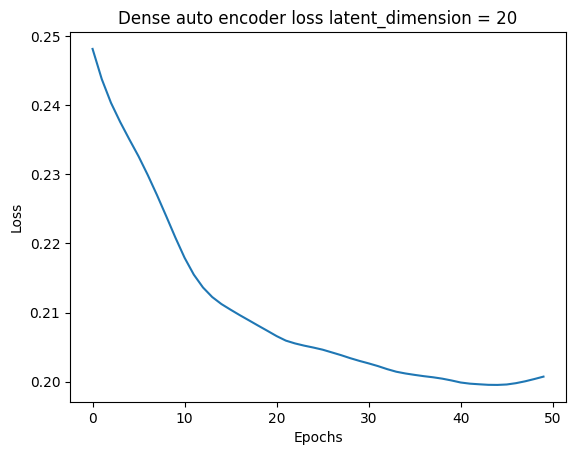

In [8]:
plt.plot(range(max_epochs), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Dense auto encoder loss latent_dimension = 20')
plt.show()

In [9]:
knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)

dense_autoencoder_x_train = dense_autoencoder_model.encode(flatten_x_train).numpy()
dense_autoencoder_x_test = dense_autoencoder_model.encode(flatten_x_test).numpy()

clf.fit(dense_autoencoder_x_train,y_train)

knn_dense_autencoder = clf.best_estimator_
print('knn score for dense autoencoder model reduction on train dataset : ',knn_dense_autencoder.score(dense_autoencoder_x_train,y_train))
print('knn score for dense autoencoder model reduction on test dataset : ',knn_dense_autencoder.score(dense_autoencoder_x_test,y_test))

knn score for dense autoencoder model reduction on train dataset :  0.7189333333333333
knn score for dense autoencoder model reduction on test dataset :  0.6836


#### latent_dimension = 10


In [10]:
latent_dimension= 10
optimizer = optimizers.legacy.SGD()
dense_autoencoder_model = DenseAutoencoder(hidden_dim,latent_dimension,original_dim)
dense_autoencoder_model.compile(loss = 'MSE',optimizer=optimizer)
history = dense_autoencoder_model.fit(flatten_x_train,flatten_x_train,epochs=max_epochs,batch_size=batch_size,validation_data=(flatten_x_test,flatten_x_test))

Epoch 1/50
235/235 [==============================] - 5s 19ms/step - loss: 0.2398 - val_loss: 0.2399
Epoch 2/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2409 - val_loss: 0.2420
Epoch 3/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2437 - val_loss: 0.2453
Epoch 4/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2469 - val_loss: 0.2481
Epoch 5/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2488 - val_loss: 0.2491
Epoch 6/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2493 - val_loss: 0.2493
Epoch 7/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2496 - val_loss: 0.2497
Epoch 8/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2500 - val_loss: 0.2501
Epoch 9/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2504 - val_loss: 0.2505
Epoch 10/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2508 - val_lo

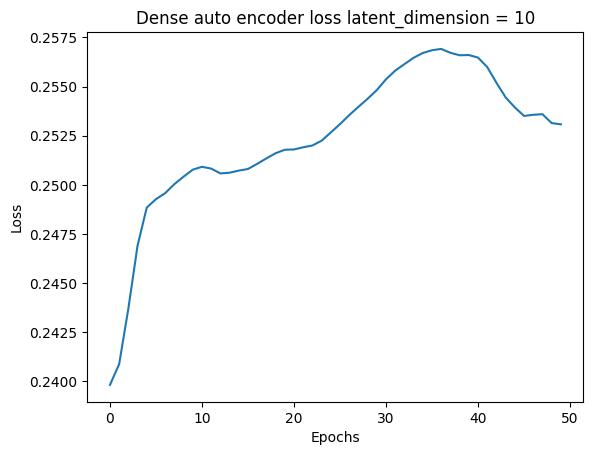

In [11]:
plt.plot(range(max_epochs), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Dense auto encoder loss latent_dimension = 10')
plt.show()

In [12]:
knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)

dense_autoencoder_x_train = dense_autoencoder_model.encode(flatten_x_train).numpy()
dense_autoencoder_x_test = dense_autoencoder_model.encode(flatten_x_test).numpy()

clf.fit(dense_autoencoder_x_train,y_train)

knn_dense_autencoder = clf.best_estimator_
print('knn score for dense autoencoder model reduction on train dataset : ',knn_dense_autencoder.score(dense_autoencoder_x_train,y_train))
print('knn score for dense autoencoder model reduction on test dataset : ',knn_dense_autencoder.score(dense_autoencoder_x_test,y_test))

knn score for dense autoencoder model reduction on train dataset :  0.6226166666666667
knn score for dense autoencoder model reduction on test dataset :  0.5924


### CNN

In [23]:
class CnnAutoencoder(Model):
    def __init__(self, filters):
        super(CnnAutoencoder, self).__init__()

        self.conv1_encoder = layers.Conv2D(filters=filters[0], kernel_size=3, strides=1,
                                   activation='relu', padding='same')
        self.conv2_encoder = layers.Conv2D(filters=filters[1], kernel_size=3, strides=1,
                                   activation='relu', padding='same')
        self.conv3_encoder = layers.Conv2D(filters=filters[2], kernel_size=3, strides=1,
                                   activation='relu', padding='same')
        self.pool = layers.MaxPooling2D((2, 2), padding='same')

        self.conv1_decoder = layers.Conv2D(filters=filters[2], kernel_size=3, strides=1,
                                   activation='relu', padding='same')
        self.conv2_decoder = layers.Conv2D(filters=filters[1], kernel_size=3, strides=1,
                                   activation='relu', padding='same')
        self.conv3_decoder = layers.Conv2D(filters=filters[0], kernel_size=3, strides=1,
                                   activation='relu', padding='valid')
        self.conv4_decoder = layers.Conv2D(1, 3, 1, activation='sigmoid',
                                   padding='same')
        self.upsample = layers.UpSampling2D((2, 2))

    def call(self, input_features):
        encoded = self.encode(input_features)
        reconstructed = self.decode(encoded)
        return reconstructed

    def encode(self, input_features):
        x = self.conv1_encoder(input_features)
        x = self.pool(x)
        x = self.conv2_encoder(x)
        x = self.pool(x)
        x = self.conv3_encoder(x)
        encoded = self.pool(x)
        return encoded

    def decode(self, encoded):
        x = self.conv1_decoder(encoded)
        x = self.upsample(x)
        x = self.conv2_decoder(x)
        x = self.upsample(x)
        x = self.conv3_decoder(x)
        x = self.upsample(x)
        reconstructed = self.conv4_decoder(x)
        return reconstructed

In [14]:
batch_size = 256
max_epochs = 50
learning_rate = 1e-3

#### filters = [32,32,16]


In [15]:
filters = [32,32,16]
optimizer = optimizers.legacy.SGD()
cnn_autoencoder_model = CnnAutoencoder(filters)
cnn_autoencoder_model.compile(loss = 'MSE',optimizer=optimizer)
history = cnn_autoencoder_model.fit(x_train,x_train,epochs=max_epochs,batch_size=batch_size,validation_data=(x_test,x_test))

Epoch 1/50
235/235 [==============================] - 20s 83ms/step - loss: 0.1551 - val_loss: 0.1400
Epoch 2/50
235/235 [==============================] - 20s 85ms/step - loss: 0.1318 - val_loss: 0.1236
Epoch 3/50
235/235 [==============================] - 19s 82ms/step - loss: 0.1144 - val_loss: 0.1011
Epoch 4/50
235/235 [==============================] - 20s 83ms/step - loss: 0.0833 - val_loss: 0.0650
Epoch 5/50
235/235 [==============================] - 20s 84ms/step - loss: 0.0559 - val_loss: 0.0499
Epoch 6/50
235/235 [==============================] - 20s 87ms/step - loss: 0.0473 - val_loss: 0.0450
Epoch 7/50
235/235 [==============================] - 20s 85ms/step - loss: 0.0434 - val_loss: 0.0420
Epoch 8/50
235/235 [==============================] - 21s 90ms/step - loss: 0.0409 - val_loss: 0.0399
Epoch 9/50
235/235 [==============================] - 20s 85ms/step - loss: 0.0392 - val_loss: 0.0385
Epoch 10/50
235/235 [==============================] - 20s 85ms/step - loss: 0.037

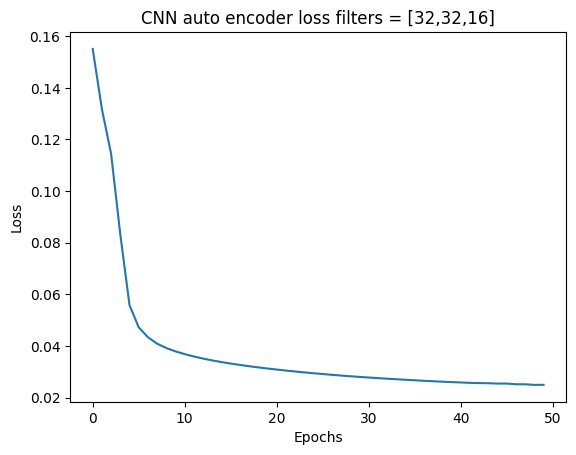

In [16]:
plt.plot(range(max_epochs), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN auto encoder loss filters = [32,32,16]')
plt.show()

In [17]:
knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)

cnn_autoencoder_x_train = cnn_autoencoder_model.encode(x_train).numpy().reshape((len(x_train),-1))
cnn_autoencoder_x_test = cnn_autoencoder_model.encode(x_test).numpy().reshape((len(x_test),-1))

clf.fit(cnn_autoencoder_x_train,y_train)

knn_cnn_autencoder = clf.best_estimator_
print('knn score for cnn_autoencoder reduction on train dataset : ',knn_cnn_autencoder.score(cnn_autoencoder_x_train,y_train))
print('knn score for cnn_autoencoder reduction on test dataset : ',knn_cnn_autencoder.score(cnn_autoencoder_x_test,y_test))

knn score for cnn_autoencoder reduction on train dataset :  0.8626666666666667
knn score for cnn_autoencoder reduction on test dataset :  0.803


#### filters = [32,32,32]


In [18]:
filters = [32,32,32]
optimizer = optimizers.legacy.SGD()
cnn_autoencoder_model = CnnAutoencoder(filters)
cnn_autoencoder_model.compile(loss = 'MSE',optimizer=optimizer)
history = cnn_autoencoder_model.fit(x_train,x_train,epochs=max_epochs,batch_size=batch_size,validation_data=(x_test,x_test))

Epoch 1/50
235/235 [==============================] - 21s 88ms/step - loss: 0.1451 - val_loss: 0.1320
Epoch 2/50
235/235 [==============================] - 21s 88ms/step - loss: 0.1293 - val_loss: 0.1263
Epoch 3/50
235/235 [==============================] - 20s 87ms/step - loss: 0.1239 - val_loss: 0.1196
Epoch 4/50
235/235 [==============================] - 20s 85ms/step - loss: 0.1125 - val_loss: 0.1013
Epoch 5/50
235/235 [==============================] - 20s 85ms/step - loss: 0.0830 - val_loss: 0.0625
Epoch 6/50
235/235 [==============================] - 20s 84ms/step - loss: 0.0519 - val_loss: 0.0459
Epoch 7/50
235/235 [==============================] - 20s 84ms/step - loss: 0.0437 - val_loss: 0.0418
Epoch 8/50
235/235 [==============================] - 20s 85ms/step - loss: 0.0405 - val_loss: 0.0393
Epoch 9/50
235/235 [==============================] - 20s 85ms/step - loss: 0.0384 - val_loss: 0.0376
Epoch 10/50
235/235 [==============================] - 20s 87ms/step - loss: 0.037

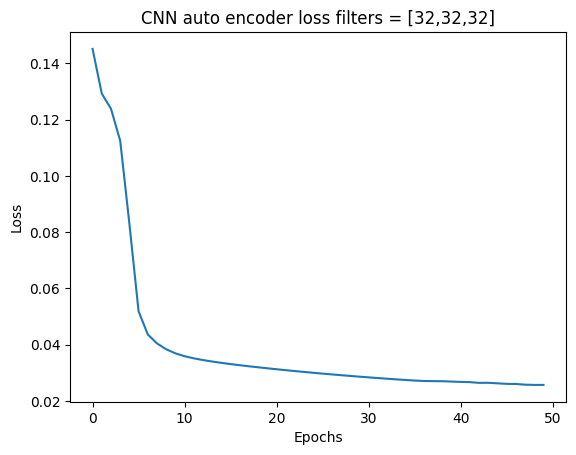

In [19]:
plt.plot(range(max_epochs), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN auto encoder loss filters = [32,32,32]')
plt.show()

In [20]:
knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)

cnn_autoencoder_x_train = cnn_autoencoder_model.encode(x_train).numpy().reshape((len(x_train),-1))
cnn_autoencoder_x_test = cnn_autoencoder_model.encode(x_test).numpy().reshape((len(x_test),-1))

clf.fit(cnn_autoencoder_x_train,y_train)

knn_cnn_autencoder = clf.best_estimator_
print('knn score for cnn_autoencoder reduction on train dataset : ',knn_cnn_autencoder.score(cnn_autoencoder_x_train,y_train))
print('knn score for cnn_autoencoder reduction on test dataset : ',knn_cnn_autencoder.score(cnn_autoencoder_x_test,y_test))

knn score for cnn_autoencoder reduction on train dataset :  0.86785
knn score for cnn_autoencoder reduction on test dataset :  0.8123
